# Determine the Age of a Person with Machine Learning

The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. You are asked to conduct that evaluation, so as you set to work, keep the following in mind:
The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol
Computer vision methods can be used to determine age of a person from a photo
The task then is to build and evaluate a model for verifying people's age

To start working on the task, you'll have a set of photographs of people with their ages indicated.

## Initialization

In [1]:
from PIL import Image

import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.isnull().sum()

file_name    0
real_age     0
dtype: int64

In [5]:
datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


The data consists of two columns, file_name and real_age. There are 7591 entries. There are no missing values.

## EDA

In [6]:
labels.shape

(7591, 2)

In [7]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

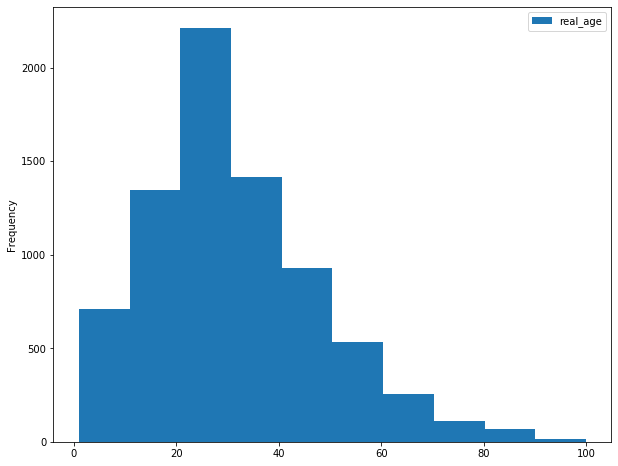

In [8]:
labels.plot(kind='hist', figsize=(10,8))

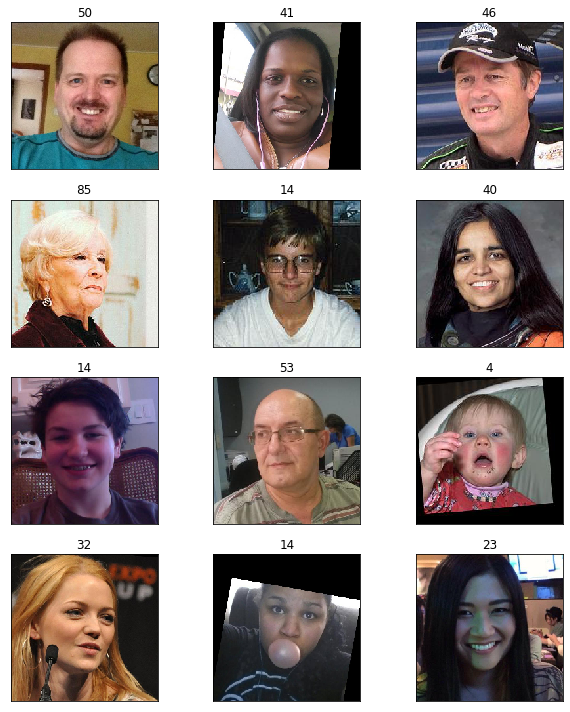

In [9]:
# images of different people and their ages
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 3, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Findings

From the description of the data, we can see that most customers are between the ages 15-40 years old. The median age of vistors is around 30 years old.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [10]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [11]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1/255)
 
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset = 'training',
        seed=12345)# place your code here

    return train_gen_flow

In [12]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255)
 
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset = 'validation',
        seed=12345)# place your code here

    return test_gen_flow

In [13]:
def create_model(input_shape):
    
    optimizer = Adam(lr = 0.0001)
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    
    model = Sequential()
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(units=120, activation='relu'))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1, activation='relu'))
              
    model.compile(optimizer=optimizer,loss='mse',metrics=['mae'])
              
    return model

In [14]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)# place your code here

    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [15]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/20
2022-01-07 01:34:40.637466: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-07 01:34:44.712530: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 115s - loss: 248.3139 - mae: 11.5027 - val_loss: 578.6220 - val_mae: 19.0448
Epoch 2/20
178/178 - 38s - loss: 97.6971 - mae: 7.5181 - val_loss: 504.7306 - val_mae: 17.3615
Epoch 3/20
178/178 - 38s - loss: 72.8783 - mae: 6.4727 - val_loss: 338.6952 - val_mae: 13.5818
Epoch 4/20
178/178 - 38s - loss: 61.5789 - mae: 5.9303 - val_loss: 147.6925 - val_mae: 8.9715
Epoch 5/20
178/178 - 38s - loss: 48.1659 - mae: 5.2688 - val_loss: 89.4659 - val_mae: 7.0870
Epoch 6/20
178/178 - 38s - loss: 41.1004 - mae: 4.8228 - val_loss: 92.6400 - val_mae: 7.3523
Epoch 7/20
178/178 - 38s - loss: 33.2080 - mae: 4.3763 - val_loss: 78.9447 - val_mae: 6.7232
Epoch 8/20
178/178 - 38s - loss: 29.4993 - mae: 4.1009 - val_loss: 74.6182 - val_mae: 6.3764
Epoch 9/20
178/178 - 38s - loss: 24.1849 - mae: 3.7423 - val_loss: 73.8669 - val_mae: 6.3734
Epoch 10/20
178/178 - 38s - loss: 22.9739 - mae: 3.6248 - val_loss: 72.2190 - val_mae: 6.2929
Epoch 11/20
178/178 - 37s - loss: 21.0917 - mae: 3.5004 - val_loss: 75.4035 - val_mae: 6.4952
Epoch 12/20
178/178 - 38s - loss: 18.6052 - mae: 3.2767 - val_loss: 118.4549 - val_mae: 8.3797
Epoch 13/20
178/178 - 38s - loss: 15.9821 - mae: 3.0094 - val_loss: 69.3342 - val_mae: 6.1936
Epoch 14/20
178/178 - 38s - loss: 14.0670 - mae: 2.8135 - val_loss: 69.2816 - val_mae: 6.1869
Epoch 15/20
178/178 - 38s - loss: 12.8533 - mae: 2.7192 - val_loss: 74.1682 - val_mae: 6.3845
Epoch 16/20
178/178 - 38s - loss: 12.1638 - mae: 2.6328 - val_loss: 75.5629 - val_mae: 6.4570
Epoch 17/20
178/178 - 38s - loss: 11.2561 - mae: 2.5569 - val_loss: 66.5180 - val_mae: 6.0507
Epoch 18/20
178/178 - 38s - loss: 11.1745 - mae: 2.5309 - val_loss: 68.7050 - val_mae: 6.2371
Epoch 19/20
178/178 - 38s - loss: 11.2363 - mae: 2.5120 - val_loss: 78.5212 - val_mae: 6.7626
Epoch 20/20
178/178 - 38s - loss: 10.5421 - mae: 2.4342 - val_loss: 75.1038 - val_mae: 6.4252
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 75.1038 - mae: 6.4252
Test MAE: 6.4252

## Conclusions

Our data has 7591 entries with two columns, file_name and real_age. We performed exploratory data analysis and found that the average age of customers was around 30 years. Most customers are between the age of 15-40 years old. Next we will create a model to measure the age of customers.

We built a convolutional neural network, using the dataset with photos of people. We created a model using ResNet architecture and trained the model on the GPU platform. We performed augmentations on the training set by using horizontal and vertical flips. The MAE score we obtained on the test set was 6.4252.

# Checklist

- [ ]  Notebook was opened
- [ ]  The code is error free
- [ ]  The cells with code have been arranged by order of execution
- [ ]  The exploratory data analysis has been performed
- [ ]  The results of the exploratory data analysis are presented in the final notebook
- [ ]  The model's MAE score is not higher than 8
- [ ]  The model training code has been copied to the final notebook
- [ ]  The model training output has been copied to the final notebook
- [ ]  The findings have been provided based on the results of the model training